# Echo State Network

In [236]:
import numpy as np
from numpy import linalg as LA
import seaborn as sns
import math
from scipy.sparse import random
import librosa
import matplotlib.pyplot as plt
from scipy.spatial import distance

The activation of internal units is updated according to

(1.6) $x(n +1) = f(W^{in} u(n +1) + Wx(n) + W_{back} y(n))$,

where $u(n+1)$ is the externally given input, and $f$ denotes the component-wise application of the individual unit's transfer function, $f$ (also known as activation function, unit output function, or squashing function). We will mostly use the sigmoid function $f = tanh$ but sometimes also consider linear networks with $f = 1$. The output is computed according to

(1.7) $y(n +1) = f_{out} (W_{out} (u(n +1),x(n +1),y(n))$,

where $(u(n+1),x(n+1),y(n))$ denotes the concatenated vector made from input, internal, and output activation vectors. We will use output transfer functions $f_{out} = tanh$ or $f_{out} = 1$; in the latter case we have linear output units.

Transfer function $f = tanh$.

## ESN CODE

In [245]:
def esn_sys(u, alpha=0.8, beta=0.1):
    np.random.seed(27)
    
    t = u.shape[0] # time len
    N = u.shape[1]

    x = np.zeros((N,))
    X = np.zeros((N,))
    D = np.zeros((N,))
    
    # random weights need to be dampened to avoid chaotic acitivity
    W0_ = random(N, N, density=0.1) # scipy.sparse.random
    W0 = W0_.toarray() # W0_.A
    W1 = np.max(LA.eigvals(W0)) * W0 
    W1[W1!=0] = 2 * W1[W1!=0] - 1 # make non sparse values between [-1,1]
    W = alpha * W1 # scale the matrix
    W = W.real
    
    W_in = np.random.rand(N, N)
    W_in = W_in * beta
    
    x = np.tanh(np.inner(W_in,u[0]) + np.inner(W,x)) # start state at 0
    
    for n in range(t-1):
        x_n = x
        x = np.tanh(np.inner(W_in,u[n+1]) + np.inner(W,x_n))

        X = np.vstack((X,x_n))
        D = np.vstack((D,np.arctanh(u[n+1]) ))

    X_inv = np.linalg.pinv(X)
    W_out = np.transpose(np.inner(X_inv, np.transpose(D)))


    diff_list = []
    Y = np.zeros((N,))

    for n in range(t-1):
        x_n = x
        x = np.tanh(np.inner(W_in,u[n+1]) + np.transpose(np.inner(W,x_n)))

        y = np.tanh(np.inner(W_out,x))
        Y = np.vstack((Y,y))

        sq_diff = np.square(y-u[n+1])
        diff_list.append(np.mean(sq_diff))

    return diff_list, X

## TESTS

### I) Predict output from $t-\delta$ away

In [7]:
# compare y and d on time axis or each on 1 axis
# sum of all (at each t): diff squared at each time step t
# W_out: x*u[n-1]
# predict output only if I'm t-delta away
# W_out: x*u[n-delta]

### II) Observe network state for common part of 2 different inputs

In [95]:
def make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0): 

    stim = np.zeros((N,)) + init_state

    s = init_state
    for n in range(0,N*10):
        s += incr_st
        add = np.zeros([N,])*init_state + s
        stim = np.vstack((stim,add))

    for n in range(1,N*10):
        s += incr_mid
        add = np.ones([N,])*mid_state  + s
        stim = np.vstack((stim,add))

    for n in range(0,N*10):
        s += incr_end
        add = np.zeros([N,])*fin_state  + s
        stim = np.vstack((stim,add))
        
    return stim

In [51]:
from sklearn.metrics import pairwise_distances

def compare_data(s1, s2):
    N = s1.shape[0]
    # euclidian distance between both x
#     result = np.array([])
    result = []
    for n in range(N):
        result.append(np.linalg.norm(s1[n]-s2[n]))
#     N = s1.shape[1]
#     result = stim1 == stim2
#     result = np.sum(result, axis=1)/N
    return result

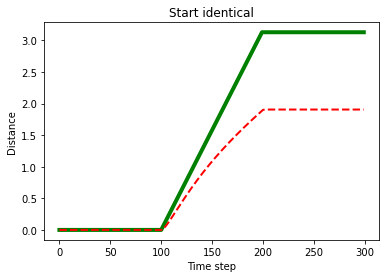

In [108]:
start_ident_neg = make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = -0.005, incr_end = 0.0)
start_ident_pos = make_stim(N=10, init_state = 0, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0)

st_neg_esn = esn_sys(start_ident_neg)[1]
st_pos_esn = esn_sys(start_ident_pos)[1]

stim_st = compare_data(start_ident_neg, start_ident_pos)
sys_st = compare_data(st_neg_esn, st_pos_esn)

plt.title("Start identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance")
plt.plot(stim_st, color ="green", linewidth=4) 
plt.plot(sys_st, color ="red", linewidth=2, linestyle='dashed') 
plt.show()   

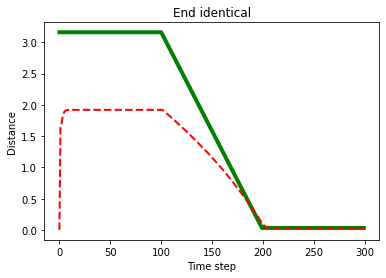

In [109]:
end_ident_neg = make_stim(N=10, init_state = - 0.5, incr_st = 0.0, incr_mid = +0.005, incr_end = 0.0)
end_ident_pos = make_stim(N=10, init_state = 0.5 , incr_st = 0.0, incr_mid = -0.005, incr_end = 0.0)
end_neg_esn = esn_sys(end_ident_neg)[1]
end_pos_esn = esn_sys(end_ident_pos)[1]

stim_end = compare_data(end_ident_neg, end_ident_pos)
sys_end = compare_data(end_neg_esn, end_pos_esn)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_end, color ="green", linewidth=4) 
plt.plot(sys_end, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

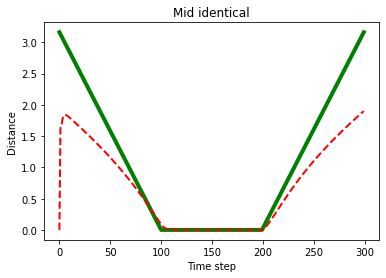

In [110]:
mid_ident_neg = make_stim(N=10, init_state = - 0.5, incr_st = 0.005, incr_mid = +0.0, incr_end = 0.005)
mid_ident_pos = make_stim(N=10, init_state = 0.5 , incr_st = -0.005, incr_mid = +0.0, incr_end = -0.005)
mid_neg_esn = esn_sys(mid_ident_neg)[1]
mid_pos_esn = esn_sys(mid_ident_pos)[1]

stim_mid = compare_data(mid_ident_neg, mid_ident_pos)
sys_mid = compare_data(mid_neg_esn, mid_pos_esn)

plt.title("Mid identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_mid, color ="green", linewidth=4) 
plt.plot(sys_mid, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

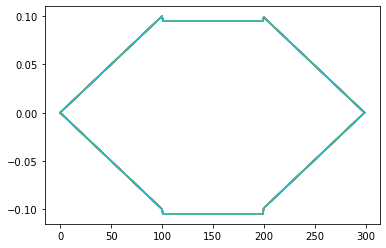

In [111]:
st_end_ident_neg = make_stim(N=10, init_state = 0, incr_st = 0.001, incr_mid = +0.0, incr_end = - 0.001)
st_end_ident_pos = make_stim(N=10, init_state = 0 , incr_st = - 0.001, incr_mid = +0.0, incr_end = + 0.001)

plt.plot(st_end_ident_neg)
plt.plot(st_end_ident_pos)

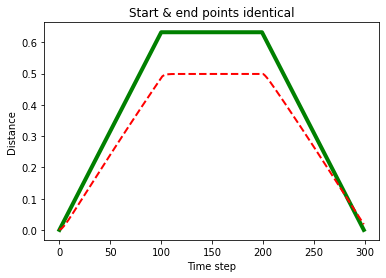

In [114]:
st_end_ident_neg = make_stim(N=10, init_state = 0, incr_st = 0.001, incr_mid = +0.0, incr_end = - 0.001)
st_end_ident_pos = make_stim(N=10, init_state = 0 , incr_st = - 0.001, incr_mid = +0.0, incr_end = + 0.001)
st_end_neg_esn = esn_sys(st_end_ident_neg)[1]
st_end_pos_esn = esn_sys(st_end_ident_pos)[1]

stim_st_end = compare_data(st_end_ident_neg, st_end_ident_pos)
sys_st_end = compare_data(st_end_neg_esn, st_end_pos_esn)

plt.title("Start & end points identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(stim_st_end, color ="green", linewidth=4) 
plt.plot(sys_st_end, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

[Text(0.5, 1.0, 'Mel-frequency spectrogram')]

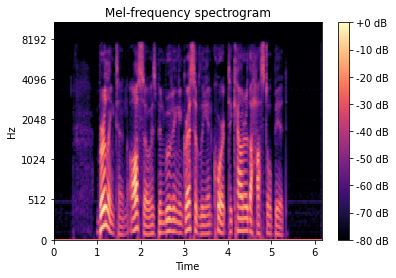

In [98]:
import librosa.display
sig, rate = librosa.load("audio.wav")
S = librosa.feature.melspectrogram(y=sig, sr=rate)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',y_axis='mel', sr=rate, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [216]:
S.shape

(128, 70)

In [154]:
u = np.transpose(S)

t = u.shape[0] # len of training data
N = u.shape[1] #int(t/15) # neuron size
alpha = 0.8 # needs to be hand tuned
x = np.zeros((N,))
    
    
# random weights need to be dampened to avoid chaotic acitivity
W0_ = random(N, N, density=0.1) # scipy.sparse.random
W0 = W0_.toarray() # W0_.A
W1 = np.max(LA.eigvals(W0))* W0 
W1[W1!=0] = 2 * W1[W1!=0] - 1 # make non sparse values between [-1,1]
W = alpha * W1 # scale the matrix
W = W.real

beta = 0.1
W_in = np.random.rand(N, N)
W_in = W_in * beta

X = np.zeros((N,))
D = np.zeros((N,))

for n in range(t-1):
    if n == 0:
        x = np.tanh(np.inner(W_in,u[n+1]) + np.inner(W,x))
        
    else:
        x_n = x
        x = np.tanh(np.inner(W_in,u[n+1]) + np.inner(W,x_n))

        X = np.vstack((X,x_n))
        D = np.vstack((D,np.arctanh(u[n]) ))

X_inv = np.linalg.pinv(X)
W_out = np.transpose(np.inner(X_inv, np.transpose(D)))


diff_list = []
Y = np.zeros((N,))

for n in range(t-1):
    x_n = x
    x = np.tanh(np.inner(W_in,u[n+1]) + np.transpose(np.inner(W,x_n)))

    y = np.tanh(np.inner(W_out,x))
    Y = np.vstack((Y,y))
    
    sq_diff = np.square(y-u[n+1])
    diff_list.append(np.mean(sq_diff))

np.sum(diff_list)

<ipython-input-154-2cb2a40513fc>:34: RuntimeWarning: invalid value encountered in arctanh
  D = np.vstack((D,np.arctanh(u[n]) ))


nan

In [184]:
import IPython.display as ipd
ipd.Audio(white_noise1, rate=16000) # load a local WAV file

In [228]:
n_arr1 = np.tile(np.random.normal(-0.5, 1.0, 30), (100,1))
n_arr2 = np.tile(np.random.normal(1.5, 0.1, 30), (100,1))
n_arr3 = np.tile(np.random.normal(0.5, 0.5, 30), (100,1))

start_id1 = np.concatenate((n_arr1, n_arr1, n_arr3))
start_id2 = np.concatenate((n_arr1, n_arr3, n_arr2))

end_id1 = np.concatenate((n_arr1, n_arr2, n_arr2))
end_id2 = np.concatenate((n_arr3, n_arr1, n_arr2))

mid_id1 = np.concatenate((n_arr1, n_arr2, n_arr3))
mid_id2 = np.concatenate((n_arr2, n_arr2, n_arr1))

<ipython-input-245-4776736b7431>:29: RuntimeWarning: invalid value encountered in arctanh
  D = np.vstack((D,np.arctanh(u[n+1]) ))


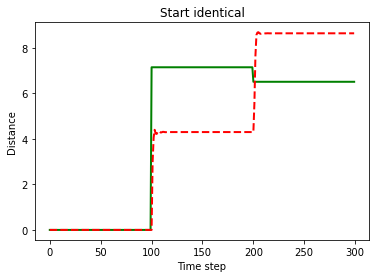

In [247]:
start_stim = compare_data(start_id1, start_id2)

start_esn1 = esn_sys(start_id1)[1]
start_esn2 = esn_sys(start_id2)[1]

start_sys = compare_data(start_esn1, start_esn2)

plt.title("Start identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(start_stim, color ="green", linewidth=2) 
plt.plot(start_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

<ipython-input-245-4776736b7431>:29: RuntimeWarning: invalid value encountered in arctanh
  D = np.vstack((D,np.arctanh(u[n+1]) ))


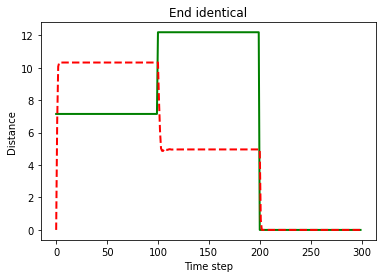

In [248]:
end_stim = compare_data(end_id1, end_id2)

end_esn1 = esn_sys(end_id1)[1]
end_esn2 = esn_sys(end_id2)[1]

end_sys = compare_data(end_esn1, end_esn2)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(end_stim, color ="green", linewidth=2) 
plt.plot(end_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 

<ipython-input-245-4776736b7431>:29: RuntimeWarning: invalid value encountered in arctanh
  D = np.vstack((D,np.arctanh(u[n+1]) ))


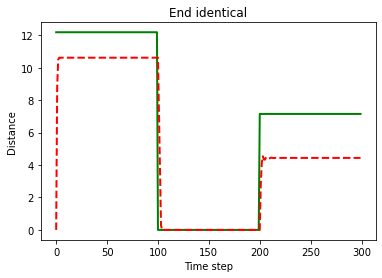

In [249]:
mid_stim = compare_data(mid_id1, mid_id2)

mid_esn1 = esn_sys(mid_id1)[1]
mid_esn2 = esn_sys(mid_id2)[1]

mid_sys = compare_data(mid_esn1, mid_esn2)

plt.title("End identical") 
plt.xlabel("Time step") 
plt.ylabel("Distance") 
plt.plot(mid_stim, color ="green", linewidth=2) 
plt.plot(mid_sys, color ="red", linewidth=2, linestyle='dashed') 
plt.show() 